# EDA and Visualization Final Project: Data Prep and Analysis
## Zachary Barnes and Bing Wang

##### Housekeeping

In [1]:
# Load Python libraries
import os
import numpy as np
import pandas as pd

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read in and organize data (Collisions and Victims datasets, from TIMS)

In [2]:
c = pd.read_csv("Collisions.csv")

# Keep only relevant columns
c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
       'LIGHTING','LOCATION_TYPE', 'ROAD_SURFACE', 'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT',
       'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'ALCOHOL_INVOLVED',
       'LATITUDE','LONGITUDE','PRIMARY_RD','SECONDARY_RD','POINT_X','POINT_Y']]

# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

# Make Collision_Date a DateTime object
c["COLLISION_DATE"] = pd.to_datetime(c.COLLISION_DATE)

# Add quarter column (use later in match speeds to collisions)
c['QUARTER'] = c['COLLISION_DATE'].map(pd.to_datetime).dt.quarter

print(len(c))
c.sample(5)

3870


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,ALCOHOL_INVOLVED,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER
2253,8636933,2018-05-20,22,N,4,C,NaN,A,H,Y,...,NaN,NaN,NaN,NaN,NaN,KIRKHAM ST,46TH AV,-122.505769,37.758572,2
1333,8716161,2018-05-07,12,Y,2,A,NaN,A,H,Y,...,NaN,NaN,NaN,NaN,NaN,MISSION ST,CORTLAND AV,-122.422840,37.741010,2
1631,8686009,2018-07-01,19,N,4,A,NaN,A,H,NaN,...,NaN,NaN,NaN,NaN,NaN,S VAN NESS AV,13TH ST,-122.417806,37.769502,3
998,8754708,2018-10-13,14,Y,3,A,NaN,A,H,Y,...,NaN,NaN,NaN,NaN,NaN,HARRISON ST,18TH ST,-122.412850,37.762250,4
2392,8630659,2018-02-13,13,N,2,A,NaN,A,H,Y,...,Y,NaN,NaN,37.73644,-122.49411,SUNSET BL,WAWONA ST,-122.494132,37.736655,1


In [3]:
# recode variables in Collision (as 1s and 0s, reduce categories down, make dummies)

# NOTE: ROAD_SURFACE and ROAD_COND_1 had some observations unstated
# If not stated, assumed no issues with road surface or con'd

# Intersection: Make dummy, intersection/not
c.loc[c.INTERSECTION == "Y", "INTERSECTION"] = 1
c.loc[c.INTERSECTION == "N", "INTERSECTION"] = 0
# Lighting: Make 1, 2, 3 for ordinal values for light, dusk/dawn, dark
c.loc[c.LIGHTING == "A", "LIGHTING"] = 2  # Light
c.loc[c.LIGHTING == "B", "LIGHTING"] = 1  # Dusk/Dawn
c.loc[c.LIGHTING.isin(["C", "D", "E"]), "LIGHTING"] = 0  # Dark (w and w/o streetlight)
# Road_Surface: Convert to dummy, wet/not 
c.loc[c.ROAD_SURFACE.isin(["B", "C", "D"]), "WET_ROAD_SURFACE"] = 1
c.loc[~(c.ROAD_SURFACE.isin(["B", "C", "D"])), "WET_ROAD_SURFACE"] = 0
# Road_Cond_1: Convert to dummy, issue/not
c.loc[c.ROAD_COND_1.isin(["H", ""]), "ROAD_COND_ISSUE"] = 0
c.loc[~(c.ROAD_COND_1.isin(["H", ""])), "ROAD_COND_ISSUE"] = 1

In [4]:
v = pd.read_csv('Victims.csv')

# Keep only relevant columns
v = v[['CASE_ID','VICTIM_DEGREE_OF_INJURY','VICTIM_ROLE','VICTIM_AGE']]

# Keep only fatalities and severe injuries (Victim_Degree_of_Injury = 1 or 2)
v = v.loc[v.VICTIM_DEGREE_OF_INJURY.isin([1, 2])]

# Make Victim Degree of Injury a categorical variable
v.loc[v.VICTIM_DEGREE_OF_INJURY == 1, "VDOI"] = "Fatalities"
v.loc[v.VICTIM_DEGREE_OF_INJURY == 2, "VDOI"] = "Severe injuries"

print(len(v))
v.head()

289


,CASE_ID,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI
13,8804193,2,1,998,Severe injuries
16,8804185,2,1,32,Severe injuries
23,8796720,2,1,30,Severe injuries
25,8796660,2,2,19,Severe injuries
31,8796604,2,1,39,Severe injuries


In [5]:
# Merge Collisions and Victims datasets
cv = pd.merge(c, v, how='left', on='CASE_ID')

print(len(cv))
print(cv.COLLISION_SEVERITY.value_counts())
print(cv.VICTIM_DEGREE_OF_INJURY.value_counts())
cv.head()

len(cv.loc[~(cv.VICTIM_DEGREE_OF_INJURY.isna())])

3882
4    2549
3    1014
2     294
1      25
Name: COLLISION_SEVERITY, dtype: int64
2.0    262
1.0     25
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64


287

In [6]:
# Paul's Function to remove NaNs from columns
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [7]:
# Convert NaNs to string type
cv = fixDFcolsForR(cv)
cv.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI
1119,8724548,2018-09-05,19,1,3,2,nan,A,H,nan,...,NATOMA ST,-122.405460,37.781950,3,0.0,0.0,NaN,NaN,NaN,nan
3234,8553221,2018-01-04,16,1,4,2,nan,A,H,nan,...,CHANNEL ST,-122.391660,37.774370,1,0.0,0.0,NaN,NaN,NaN,nan
922,8754798,2018-10-04,8,0,4,2,nan,A,H,nan,...,LAGUNA ST,-122.426289,37.773589,4,0.0,0.0,NaN,NaN,NaN,nan
3267,8553172,2018-01-11,11,0,4,2,nan,A,H,nan,...,HAYES ST,-122.429510,37.775902,1,0.0,0.0,NaN,NaN,NaN,nan
681,8758217,2018-11-03,11,1,4,2,nan,A,H,nan,...,QUESADA AV,-122.397680,37.736880,4,0.0,0.0,NaN,NaN,NaN,nan


In [8]:
# for dummies: recode Y as 1, blank as 0
def Yfor1(df):
    df = df.replace("Y", 1)
    df = df.replace("nan", 0)
    return df

In [9]:
cv["PEDESTRIAN_ACCIDENT"] = Yfor1(cv.PEDESTRIAN_ACCIDENT)
cv["BICYCLE_ACCIDENT"] = Yfor1(cv.BICYCLE_ACCIDENT)
cv["MOTORCYCLE_ACCIDENT"] = Yfor1(cv.MOTORCYCLE_ACCIDENT)
cv["TRUCK_ACCIDENT"] = Yfor1(cv.TRUCK_ACCIDENT)
cv["ALCOHOL_INVOLVED"] = Yfor1(cv.ALCOHOL_INVOLVED)

In [10]:
cv.sample(10)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI
3732,90838015,2018-10-05,17,0,4,2,nan,A,H,0,...,ALANA WAY,-122.395376,37.709459,4,0.0,0.0,NaN,NaN,NaN,nan
1978,8656362,2018-06-14,9,1,4,2,nan,A,H,1,...,EARL ST,-122.373180,37.728630,2,0.0,0.0,NaN,NaN,NaN,nan
1454,8698258,2018-08-08,15,1,4,2,nan,A,H,0,...,SOUTH PARK,-122.392850,37.782470,3,0.0,0.0,NaN,NaN,NaN,nan
702,8758189,2018-11-01,17,1,2,2,nan,A,-,0,...,PLYMOUTH AV,-122.456540,37.723980,4,0.0,1.0,2.0,1.0,26.0,Severe injuries
648,8758258,2018-11-21,11,1,4,2,nan,B,H,1,...,PINE ST,-122.417200,37.790040,4,1.0,0.0,NaN,NaN,NaN,nan
1187,8716560,2018-09-11,20,1,3,0,nan,A,H,0,...,GOLDEN GATE AV,-122.431940,37.779560,3,0.0,0.0,NaN,NaN,NaN,nan
1644,8685929,2018-07-22,13,1,4,2,nan,A,H,1,...,15TH ST,-122.410620,37.766900,3,0.0,0.0,NaN,NaN,NaN,nan
581,8758396,2018-11-13,18,0,3,1,nan,A,G,0,...,HENRY ADAMS ST,NaN,NaN,4,0.0,1.0,NaN,NaN,NaN,nan
483,8777076,2018-12-04,18,1,4,0,nan,B,H,0,...,CABRILLO ST,-122.483240,37.774490,4,1.0,0.0,NaN,NaN,NaN,nan
2373,8636792,2018-05-26,11,-,3,0,nan,A,H,0,...,SHAFTER AV 1467,NaN,NaN,2,0.0,0.0,NaN,NaN,NaN,nan


Now, we need to attach Open Street Maps (OSM) way IDs to each observation in the Collisions-Victims dataset, in order to match with the speed dataset. An OSM way ID is an ID that matches latitude and longitude to a street segment.

# Use Nominatim API to convert lat long to OSM ID

In [11]:
# import requests
# import json

# def osmid(lat,lon):
#     URL = 'https://nominatim.openstreetmap.org/reverse?format=json&lat=%s&lon=%s'
#     r = requests.get(URL % (lat,lon))
#     data = json.loads(r.text)
# #     osm_id = data.get('osm_id','NONE')
#     return data['osm_id']


This code snippet below creates osm.csv, a list of OSM IDS and their latitudes and longitudes. We will use this to attach OSM IDs to our Collisions-Victims dataset.

In [12]:
# import time
# lat_long = cv[['POINT_Y','POINT_X','VICTIM_DEGREE_OF_INJURY']]
# osm_id = list()
# for i,row in lat_long.iterrows():
#     if (np.isnan(row['POINT_Y']) or np.isnan(row['POINT_X'])) or np.isnan(row['VICTIM_DEGREE_OF_INJURY']):
#         osm_id.append('NONE')
#         continue
#     else:
#         time.sleep(2)
#         osm_id.append(osmid(row['POINT_Y'],row['POINT_X']))
# osm_series = pd.Series(osm_id)
# osm_series.to_csv('osm.csv')

# Add OSM_ID column 

In [13]:
# since we have preprocessed and saved OSM ID data, just read in as csv
osm = pd.read_csv('osm.csv',header=None)
osm.columns = ['index','OSM_ID']
cv['OSM_ID'] = osm['OSM_ID']

print(len(cv))
print(len(osm))
cv.loc[~(cv.VICTIM_DEGREE_OF_INJURY.isna())].sample(5)

3882
3882


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,POINT_X,POINT_Y,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI,OSM_ID
1222,8716526,2018-09-04,6,1,2,0,nan,A,H,0,...,-122.419900,37.786830,3,0.0,0.0,2.0,4.0,26.0,Severe injuries,4628615917
3444,8465618,2018-10-03,21,0,1,0,nan,A,H,1,...,-122.440709,37.772706,4,0.0,0.0,1.0,3.0,60.0,Fatalities,513962743
2365,8636809,2018-05-17,22,1,2,0,nan,A,H,1,...,-122.468370,37.768790,2,0.0,0.0,2.0,3.0,26.0,Severe injuries,255166635
398,8777283,2018-12-28,16,1,2,2,nan,A,H,0,...,-122.424680,37.793730,4,0.0,0.0,2.0,1.0,29.0,Severe injuries,224384016
2698,8598020,2018-03-27,4,0,2,0,nan,A,H,0,...,-122.389340,37.738836,1,0.0,0.0,2.0,2.0,48.0,Severe injuries,287939964


# Load in Uber Speeds dataset

Load avgspeeds.csv, the Uber Speeds dataset, and reduce down to speeds.csv (see comment below code)

In [14]:
# avgspeeds = pd.read_csv('avgspeeds.csv')
# avgspeeds.head()

In [15]:
# speeds = list()
# for i, row in cvsmall.iterrows():
#     speed = avgspeeds.loc[(avgspeeds['osm_way_id'] == row['OSM_ID']) & 
#               (avgspeeds['quarter'] == row['QUARTER']) & 
#               (avgspeeds['hour_of_day'] == row['COLLISION_TIME'])]['speed_mph_mean']
#     if speed.values.size > 0:
#          speeds.append(speed.values[0])
        
#     else:
#         speeds.append(0)
# speeds = pd.Series(speeds)
# speeds.to_csv('speeds.csv')


In [16]:
# Reduce cv DataFrame to only entries with non-null Quarter, Collision_Time, and OSM_ID 
# before joining to avgspeeds
cvsmall = cv.loc[(~cv['QUARTER'].isna()) & (~cv['COLLISION_TIME'].isna()) & ~(cv['OSM_ID'] == 'NONE')]
#cvsmall['OSM_ID'] = cvsmall['OSM_ID'].astype(int)

# NOTE 10/1: Commented out as this resulting in error "AttributeError: 'int' object has no attribute 'encode'"

# There are 271 entries.
len(cv.loc[~(cv['OSM_ID'] == 'NONE')])

271

The code below produces speeds.csv, a subset of averagespeeds.csv. It reduces the speeds observations down to ones that would match the Collisions-Victims dataset on OSD_ID, Quarter, and Collision_Time. If there is no match, set speed = 0.

Now, we join cvsmall (the reduced Collisions-Victims dataset) to the speeds dataset.

In [17]:
speeds = pd.read_csv("speeds.csv",header=None)

cvsmall["SPEEDS"] = speeds[1].to_list()
cvsmall.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,POINT_Y,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI,OSM_ID,SPEEDS
251,8804185,2018-12-29,18,1,2,0,nan,A,H,0,...,37.746940,4,0.0,0.0,2.0,1.0,32.0,Severe injuries,148313526,7.753
254,8796720,2018-12-10,13,0,2,2,nan,A,H,0,...,37.805128,4,0.0,0.0,2.0,1.0,30.0,Severe injuries,2503369217,0.000
260,8796604,2018-12-28,18,0,2,0,nan,A,H,0,...,37.777302,4,0.0,0.0,2.0,1.0,39.0,Severe injuries,3802986672,0.000
261,8796085,2018-12-11,15,0,2,2,nan,A,H,0,...,37.779838,4,0.0,0.0,2.0,1.0,45.0,Severe injuries,467150002,0.000
266,8787863,2018-12-12,9,0,2,2,nan,A,H,1,...,37.774759,4,0.0,0.0,2.0,2.0,998.0,Severe injuries,27553863,0.000


Drop accidents on highways (not covered by Vision Zero SF)

In [18]:
cvsmall = cvsmall.loc[cvsmall.LOCATION_TYPE != "H"]
len(cvsmall)

266

# Preliminary graphs (without speed or regressions)

In [19]:
# fix NaNs with Paul's function before passing to R
cvsmall = fixDFcolsForR(cvsmall)

In [20]:
cvsmall.dtypes

CASE_ID                             int64
COLLISION_DATE             datetime64[ns]
COLLISION_TIME                      int64
INTERSECTION                       object
COLLISION_SEVERITY                  int64
LIGHTING                           object
LOCATION_TYPE                      object
ROAD_SURFACE                       object
ROAD_COND_1                        object
PEDESTRIAN_ACCIDENT                 int64
BICYCLE_ACCIDENT                    int64
MOTORCYCLE_ACCIDENT                 int64
TRUCK_ACCIDENT                      int64
ALCOHOL_INVOLVED                    int64
LATITUDE                          float64
LONGITUDE                         float64
PRIMARY_RD                         object
SECONDARY_RD                       object
POINT_X                           float64
POINT_Y                           float64
QUARTER                             int64
WET_ROAD_SURFACE                  float64
ROAD_COND_ISSUE                   float64
VICTIM_DEGREE_OF_INJURY           

In [21]:
# Add column of months for graphing time series
cvsmall["Month"] = cvsmall.COLLISION_DATE.dt.month

len(cvsmall)

# Aggregate up to month
cvsmall_m = cvsmall.groupby(["VDOI", "Month"]).count().reset_index()

In [22]:
cvs = cvsmall.loc[cvsmall.SPEEDS != 0]
cvs.head()
print(cvs.VDOI.value_counts())
len(cvs)

Severe injuries    94
Fatalities          7
Name: VDOI, dtype: int64


101

# Chart 1: Time Series line graph of incidences of accidents
(maybe try: cumulative?)

In [23]:
%R -i cvsmall
%R -i cvsmall_m
%R -i cvs

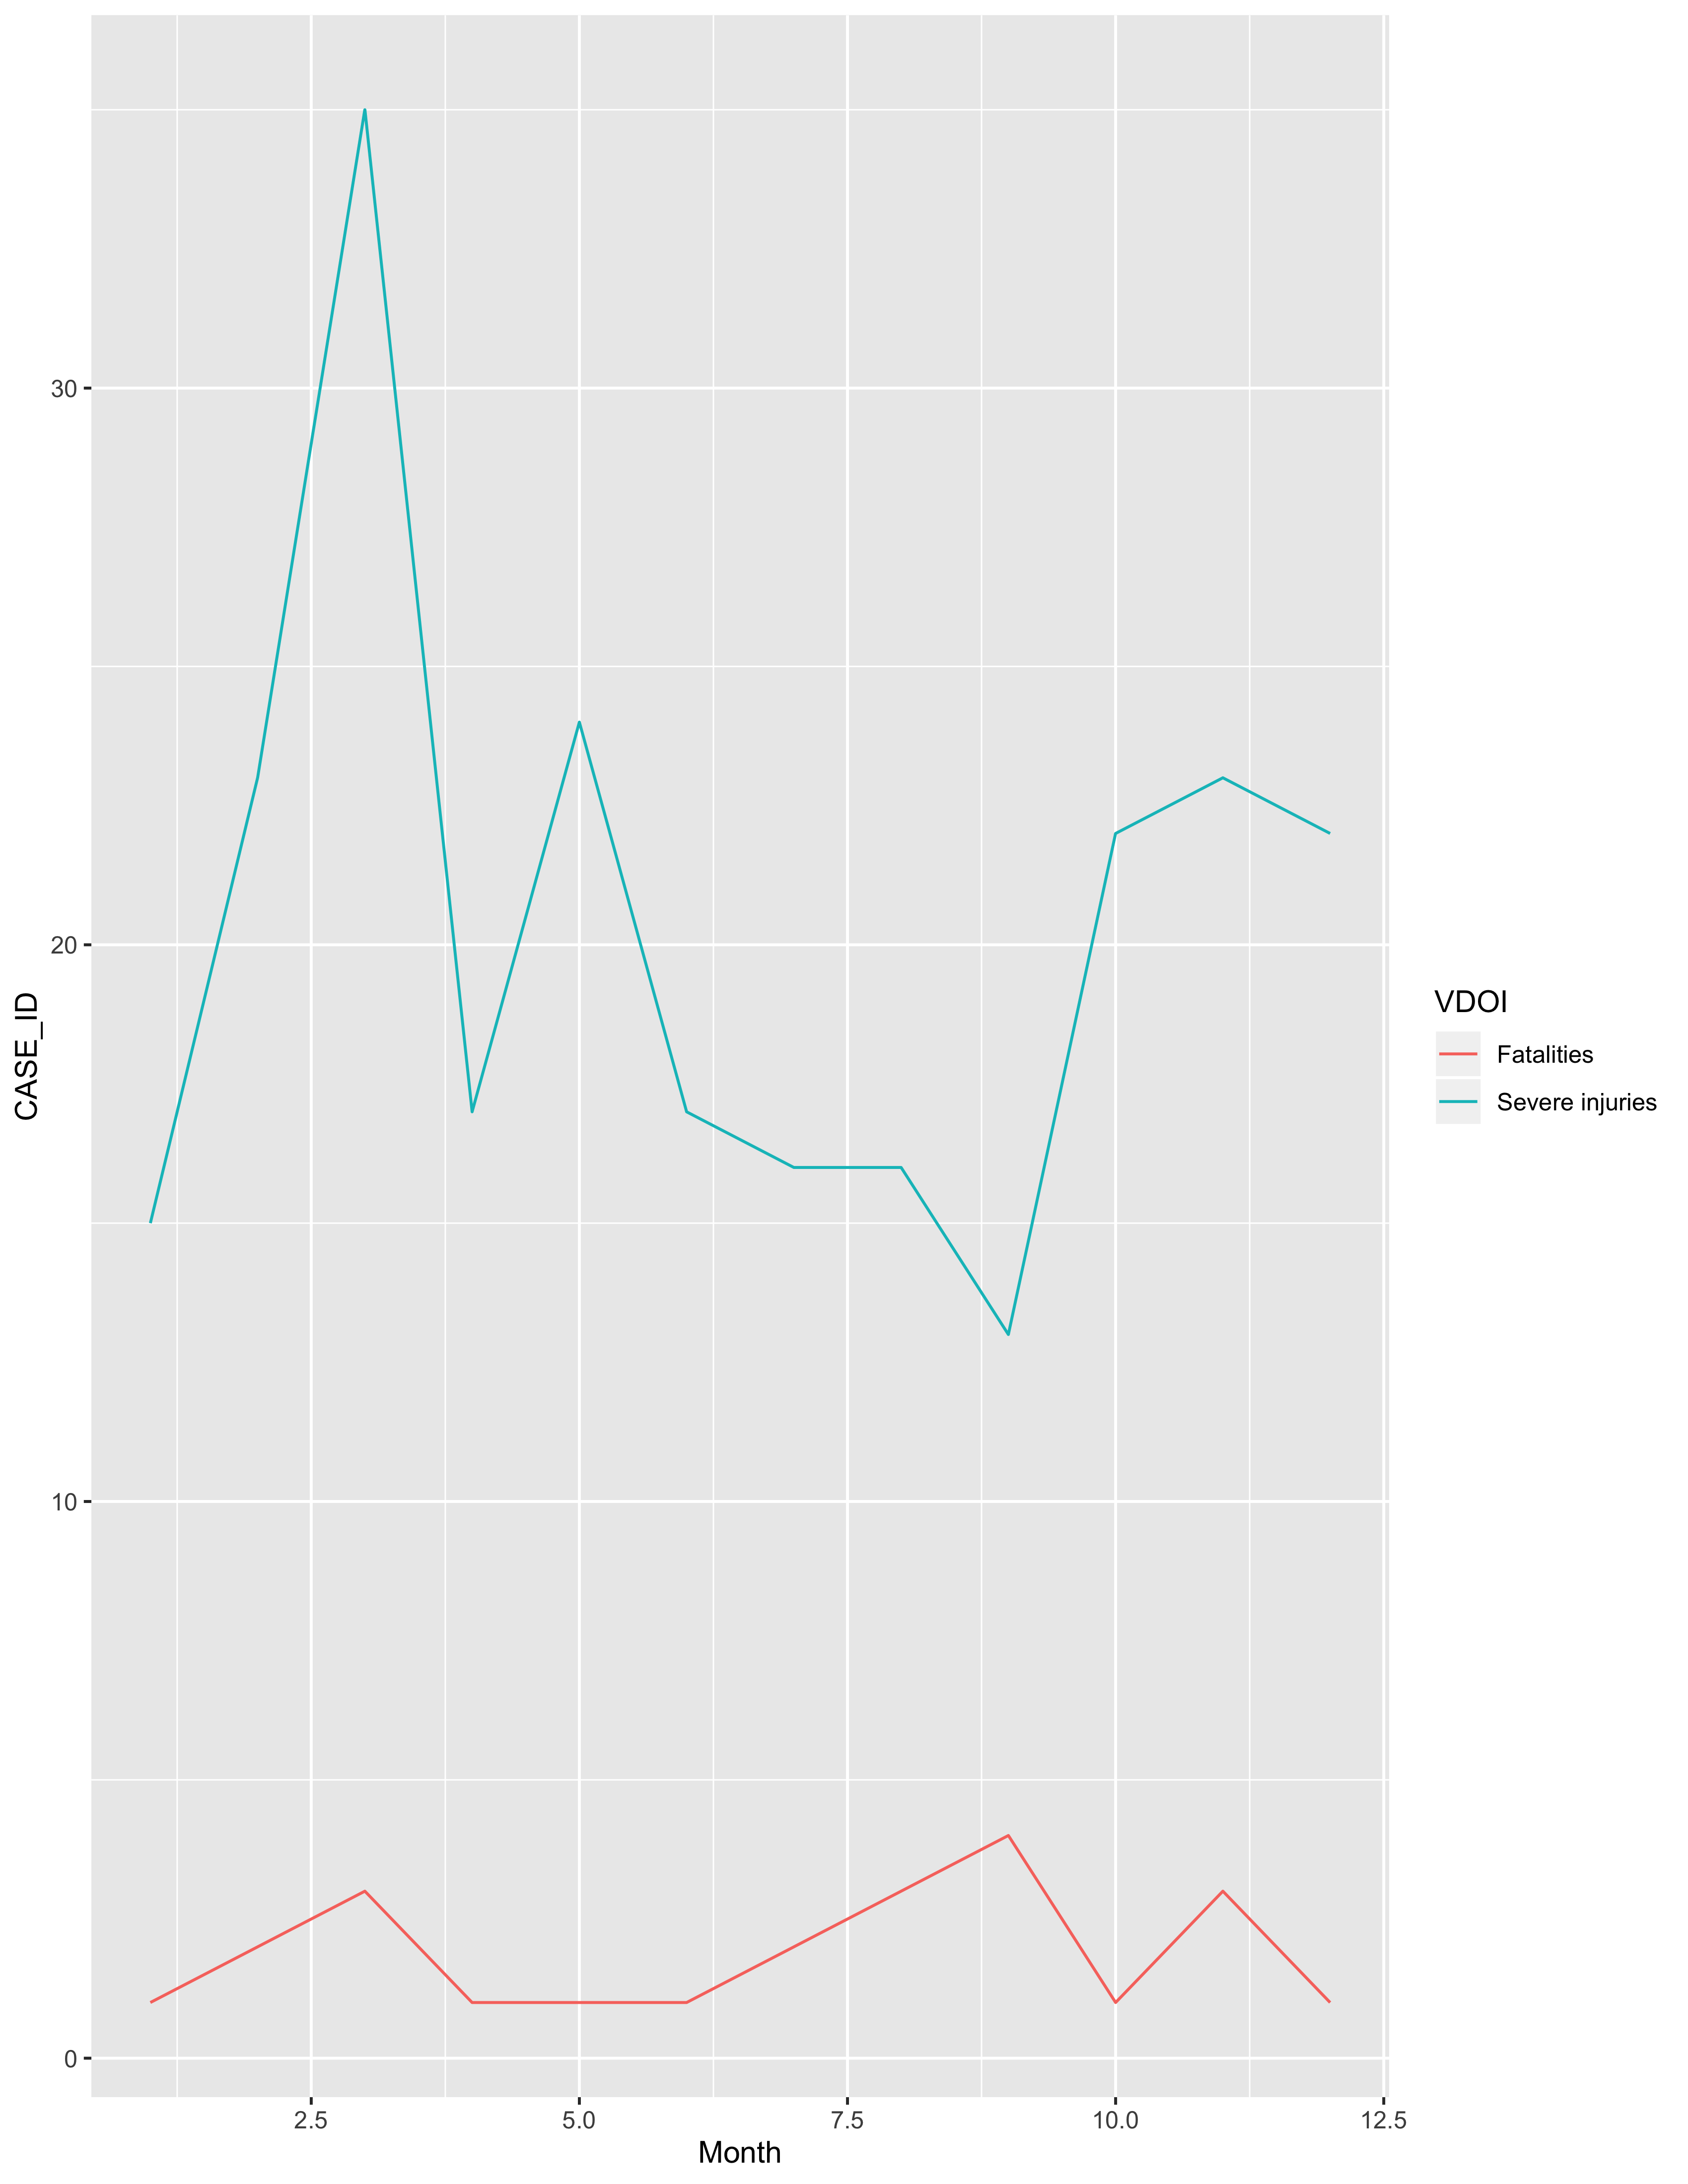

In [24]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_line(aes(x = Month, y = CASE_ID, color = VDOI), 
          data = cvsmall_m, stat = "identity") 



# Chart 2: Map

In [25]:
%%R -w 8.5 -h 11 --units in -r 400

qmplot(POINT_X, POINT_Y, data = cvsmall, maptype = "toner-lite", color = COLLISION_SEVERITY)

R[write to console]: Error in qmplot(POINT_X, POINT_Y, data = cvsmall, maptype = "toner-lite",  : 
  could not find function "qmplot"
Calls: <Anonymous> -> <Anonymous> -> withVisible




Error in qmplot(POINT_X, POINT_Y, data = cvsmall, maptype = "toner-lite",  : 
  could not find function "qmplot"
Calls: <Anonymous> -> <Anonymous> -> withVisible


# Chart 3: Box plot showing spread of speeds by victim degree of injury

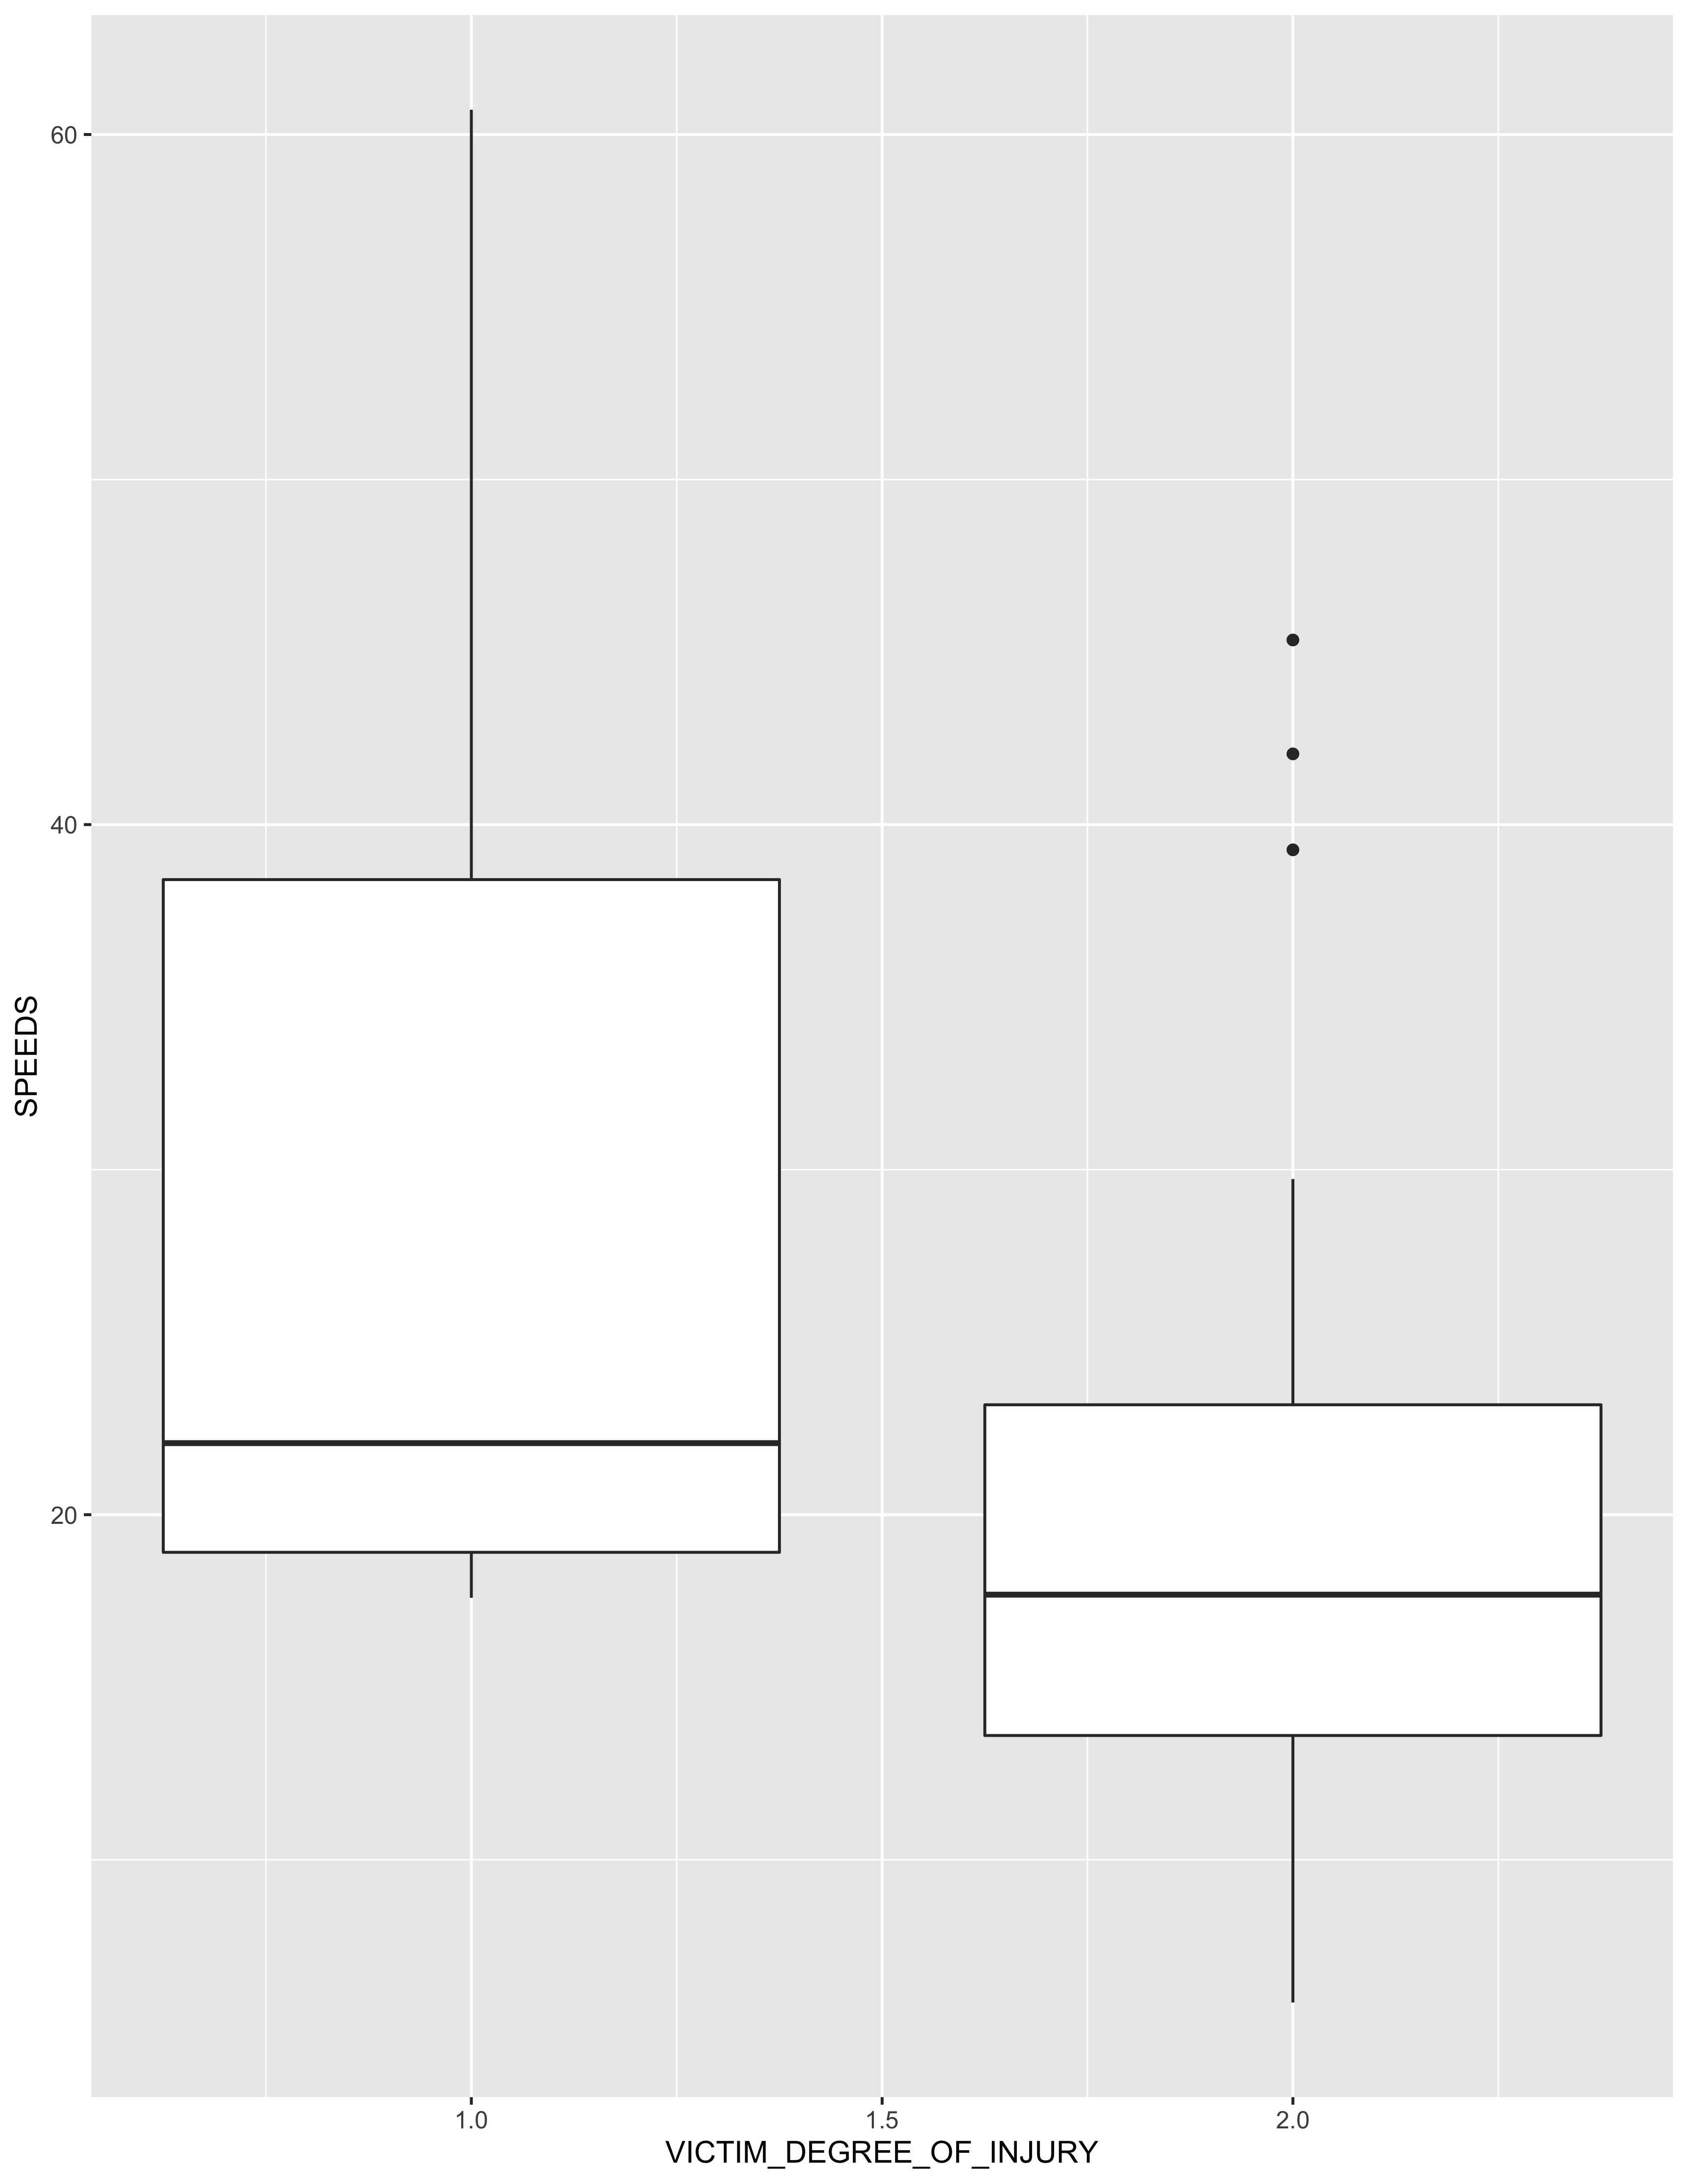

In [26]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
    geom_boxplot(aes(x=VICTIM_DEGREE_OF_INJURY, y=SPEEDS, group = VICTIM_DEGREE_OF_INJURY),data=cvs)

# (Optional) Chart ?: Histogram of ages by victim degree of injury 
(purpose: try to show that as age goes up, fatalities go up (?))

In [27]:
# remove nonsensical/placeholder VICTIM_AGE (=998?)
v_cleanage = v.loc[v.VICTIM_AGE < 150]
v_cleanage = v_cleanage.groupby(["VDOI", "VICTIM_AGE"]).count().reset_index()
v_cleanage.dtypes

VDOI                       object
VICTIM_AGE                  int64
CASE_ID                     int64
VICTIM_DEGREE_OF_INJURY     int64
VICTIM_ROLE                 int64
dtype: object

In [28]:
%R -i v_cleanage

R[write to console]: Warning:
R[write to console]:  Ignoring unknown parameters: binwidth, bins, pad



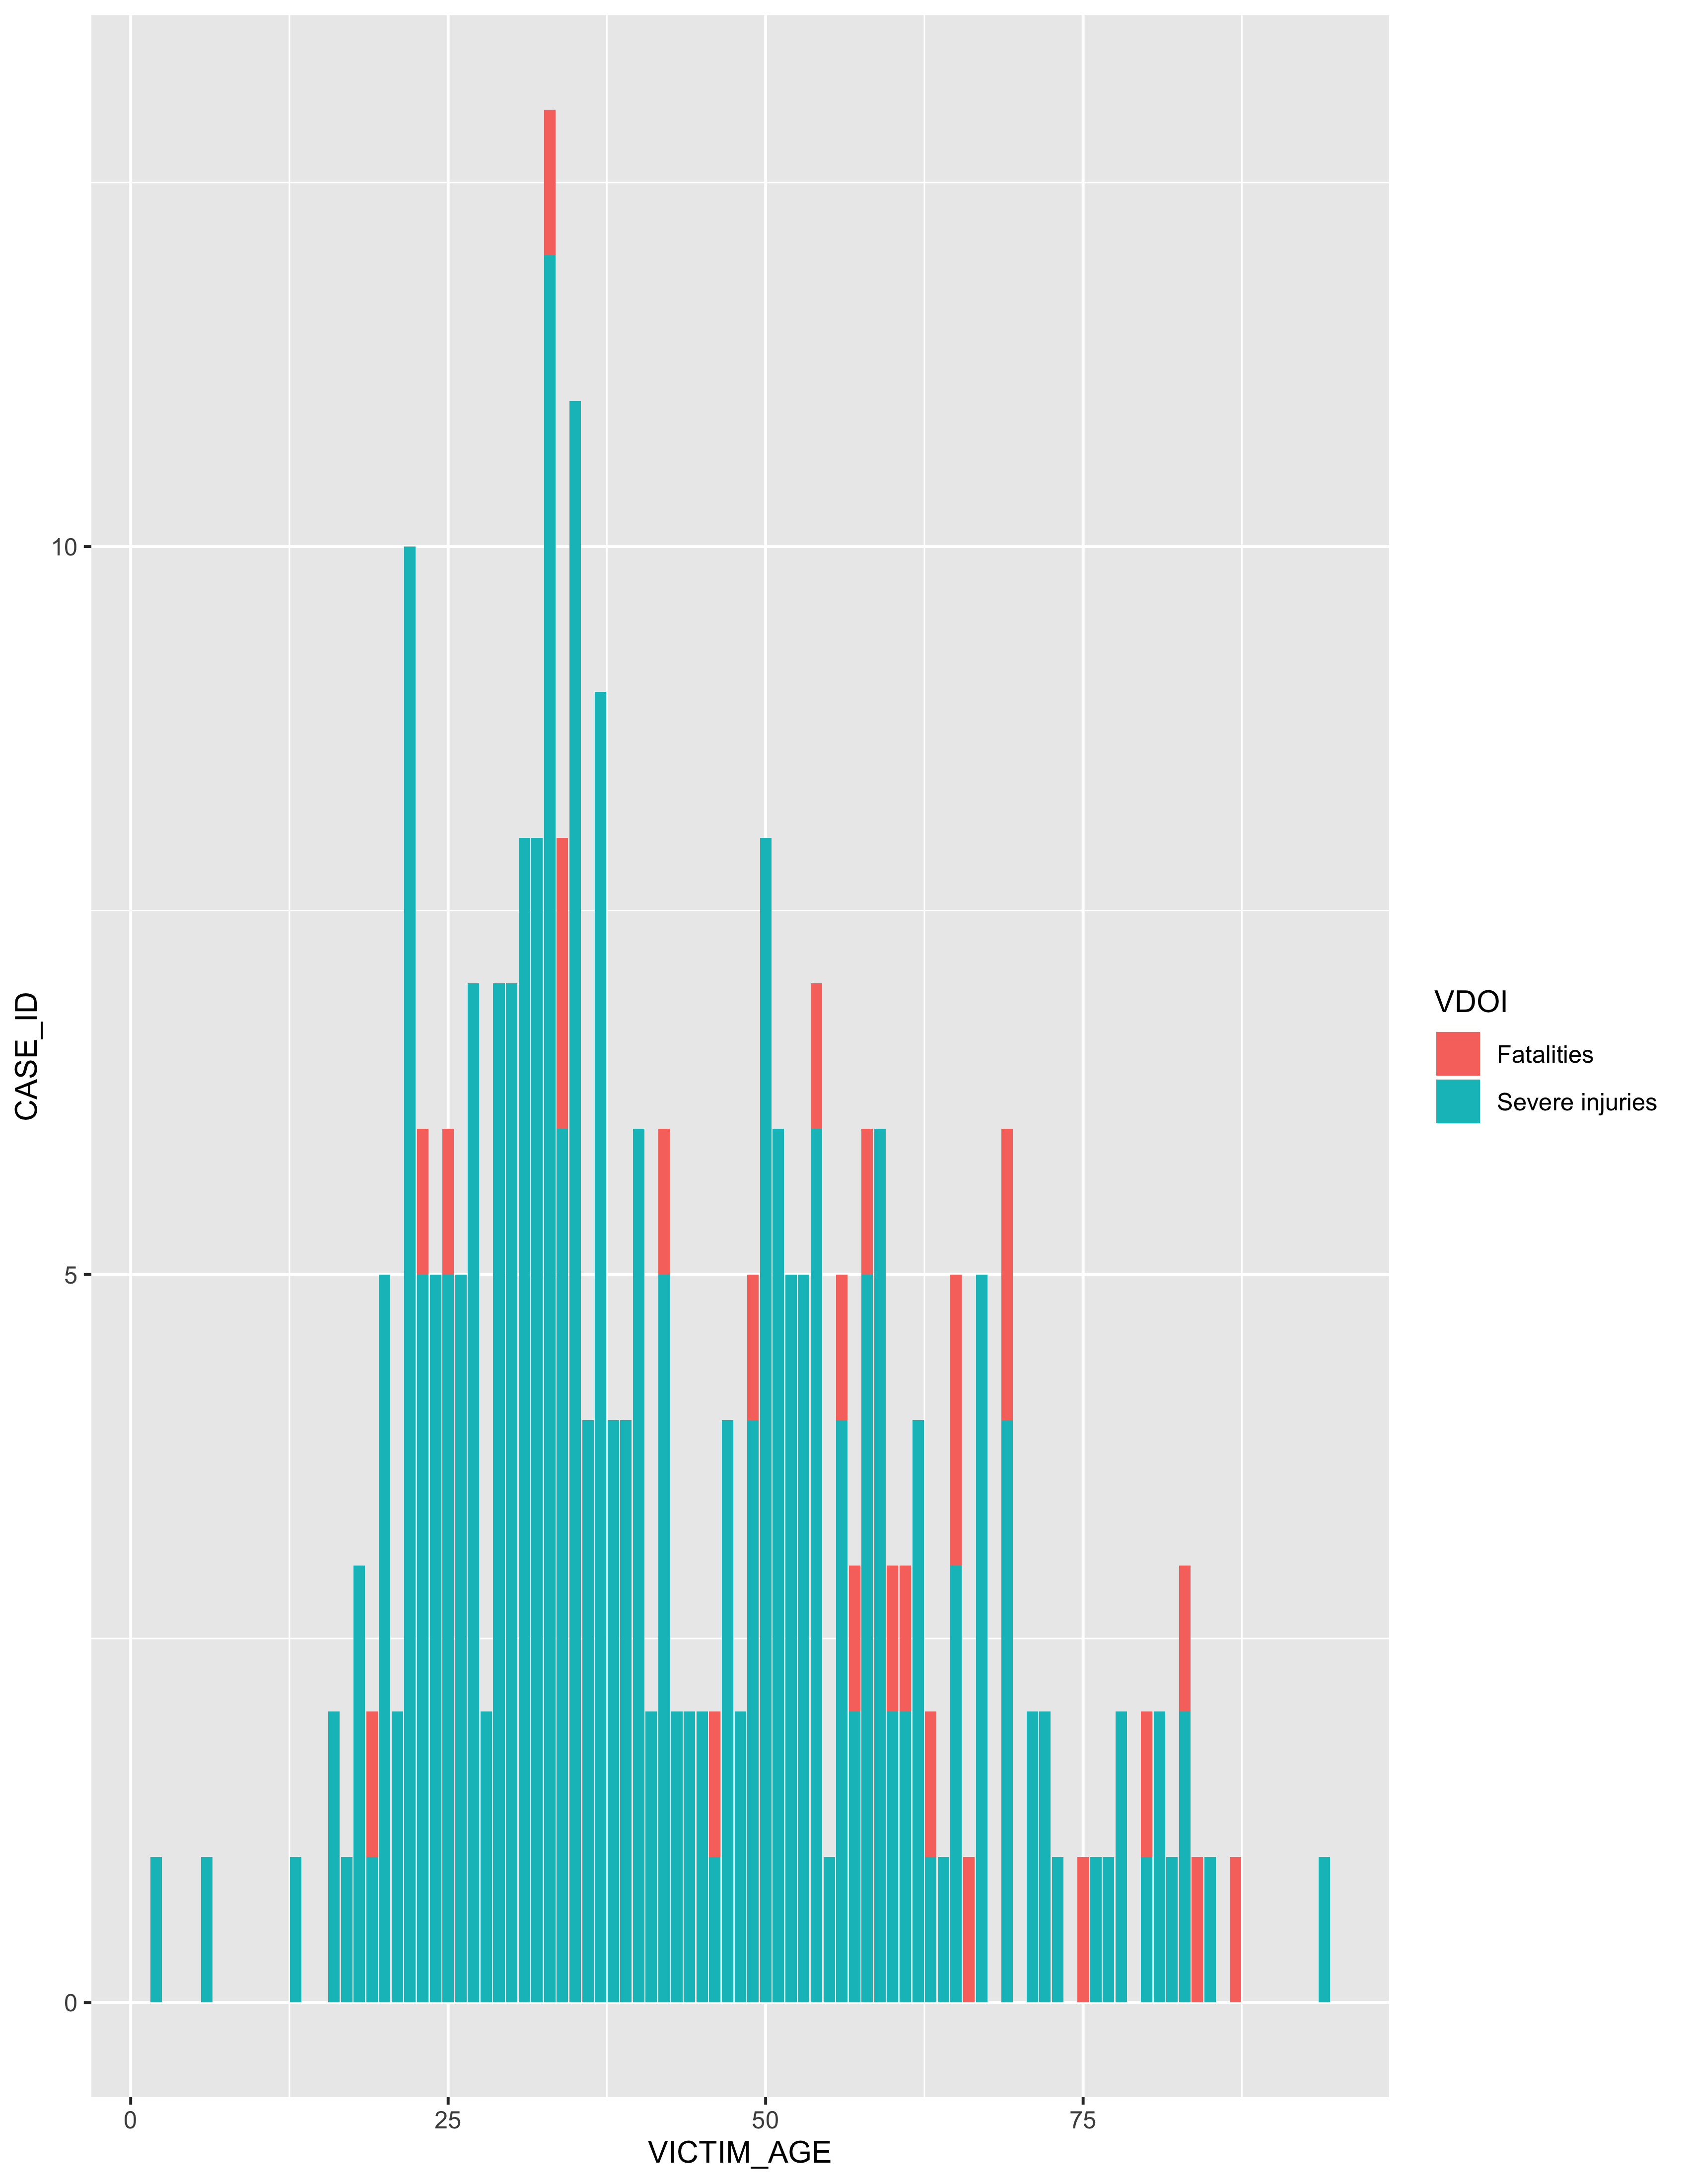

In [29]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_histogram(aes(x = VICTIM_AGE, y = CASE_ID, fill = VDOI), data = v_cleanage, 
               stat = "identity", binwidth = 10)


# Chart 4: Scatterplot of age vs. speed by Victim Degree of Injury

In [30]:
cvs.head()

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,QUARTER,WET_ROAD_SURFACE,ROAD_COND_ISSUE,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,VDOI,OSM_ID,SPEEDS,Month
251,8804185,2018-12-29,18,1,2,0,nan,A,H,0,...,4,0.0,0.0,2.0,1.0,32.0,Severe injuries,148313526,7.753,12
348,8777340,2018-12-01,22,0,2,0,nan,A,H,1,...,4,0.0,0.0,2.0,3.0,998.0,Severe injuries,27396883,11.451,12
367,8777316,2018-12-02,22,1,2,0,nan,A,H,0,...,4,0.0,0.0,2.0,2.0,29.0,Severe injuries,8914988,23.761,12
375,8777306,2018-12-27,13,1,2,2,nan,A,H,0,...,4,0.0,0.0,2.0,1.0,23.0,Severe injuries,8916919,11.359,12
398,8777283,2018-12-28,16,1,2,2,nan,A,H,0,...,4,0.0,0.0,2.0,1.0,29.0,Severe injuries,224384016,12.138,12


In [31]:
# drop the nonsensical/placeholder ages 
cvs_age = cvs.loc[cvs.VICTIM_AGE < 150]

In [32]:
# group by vic. deg. of inj. to plot mean ("centroid")
cvs_age_ag = cvs.groupby("VDOI").median().reset_index()[["VDOI", "VICTIM_AGE", "SPEEDS"]]
cvs_age_ag

,VDOI,VICTIM_AGE,SPEEDS
0,Fatalities,60.0,22.0740
1,Severe injuries,37.0,17.6825


In [33]:
%R -i cvs_age
%R -i cvs_age_ag

In [34]:
cvs.VDOI.value_counts()

Severe injuries    94
Fatalities          7
Name: VDOI, dtype: int64

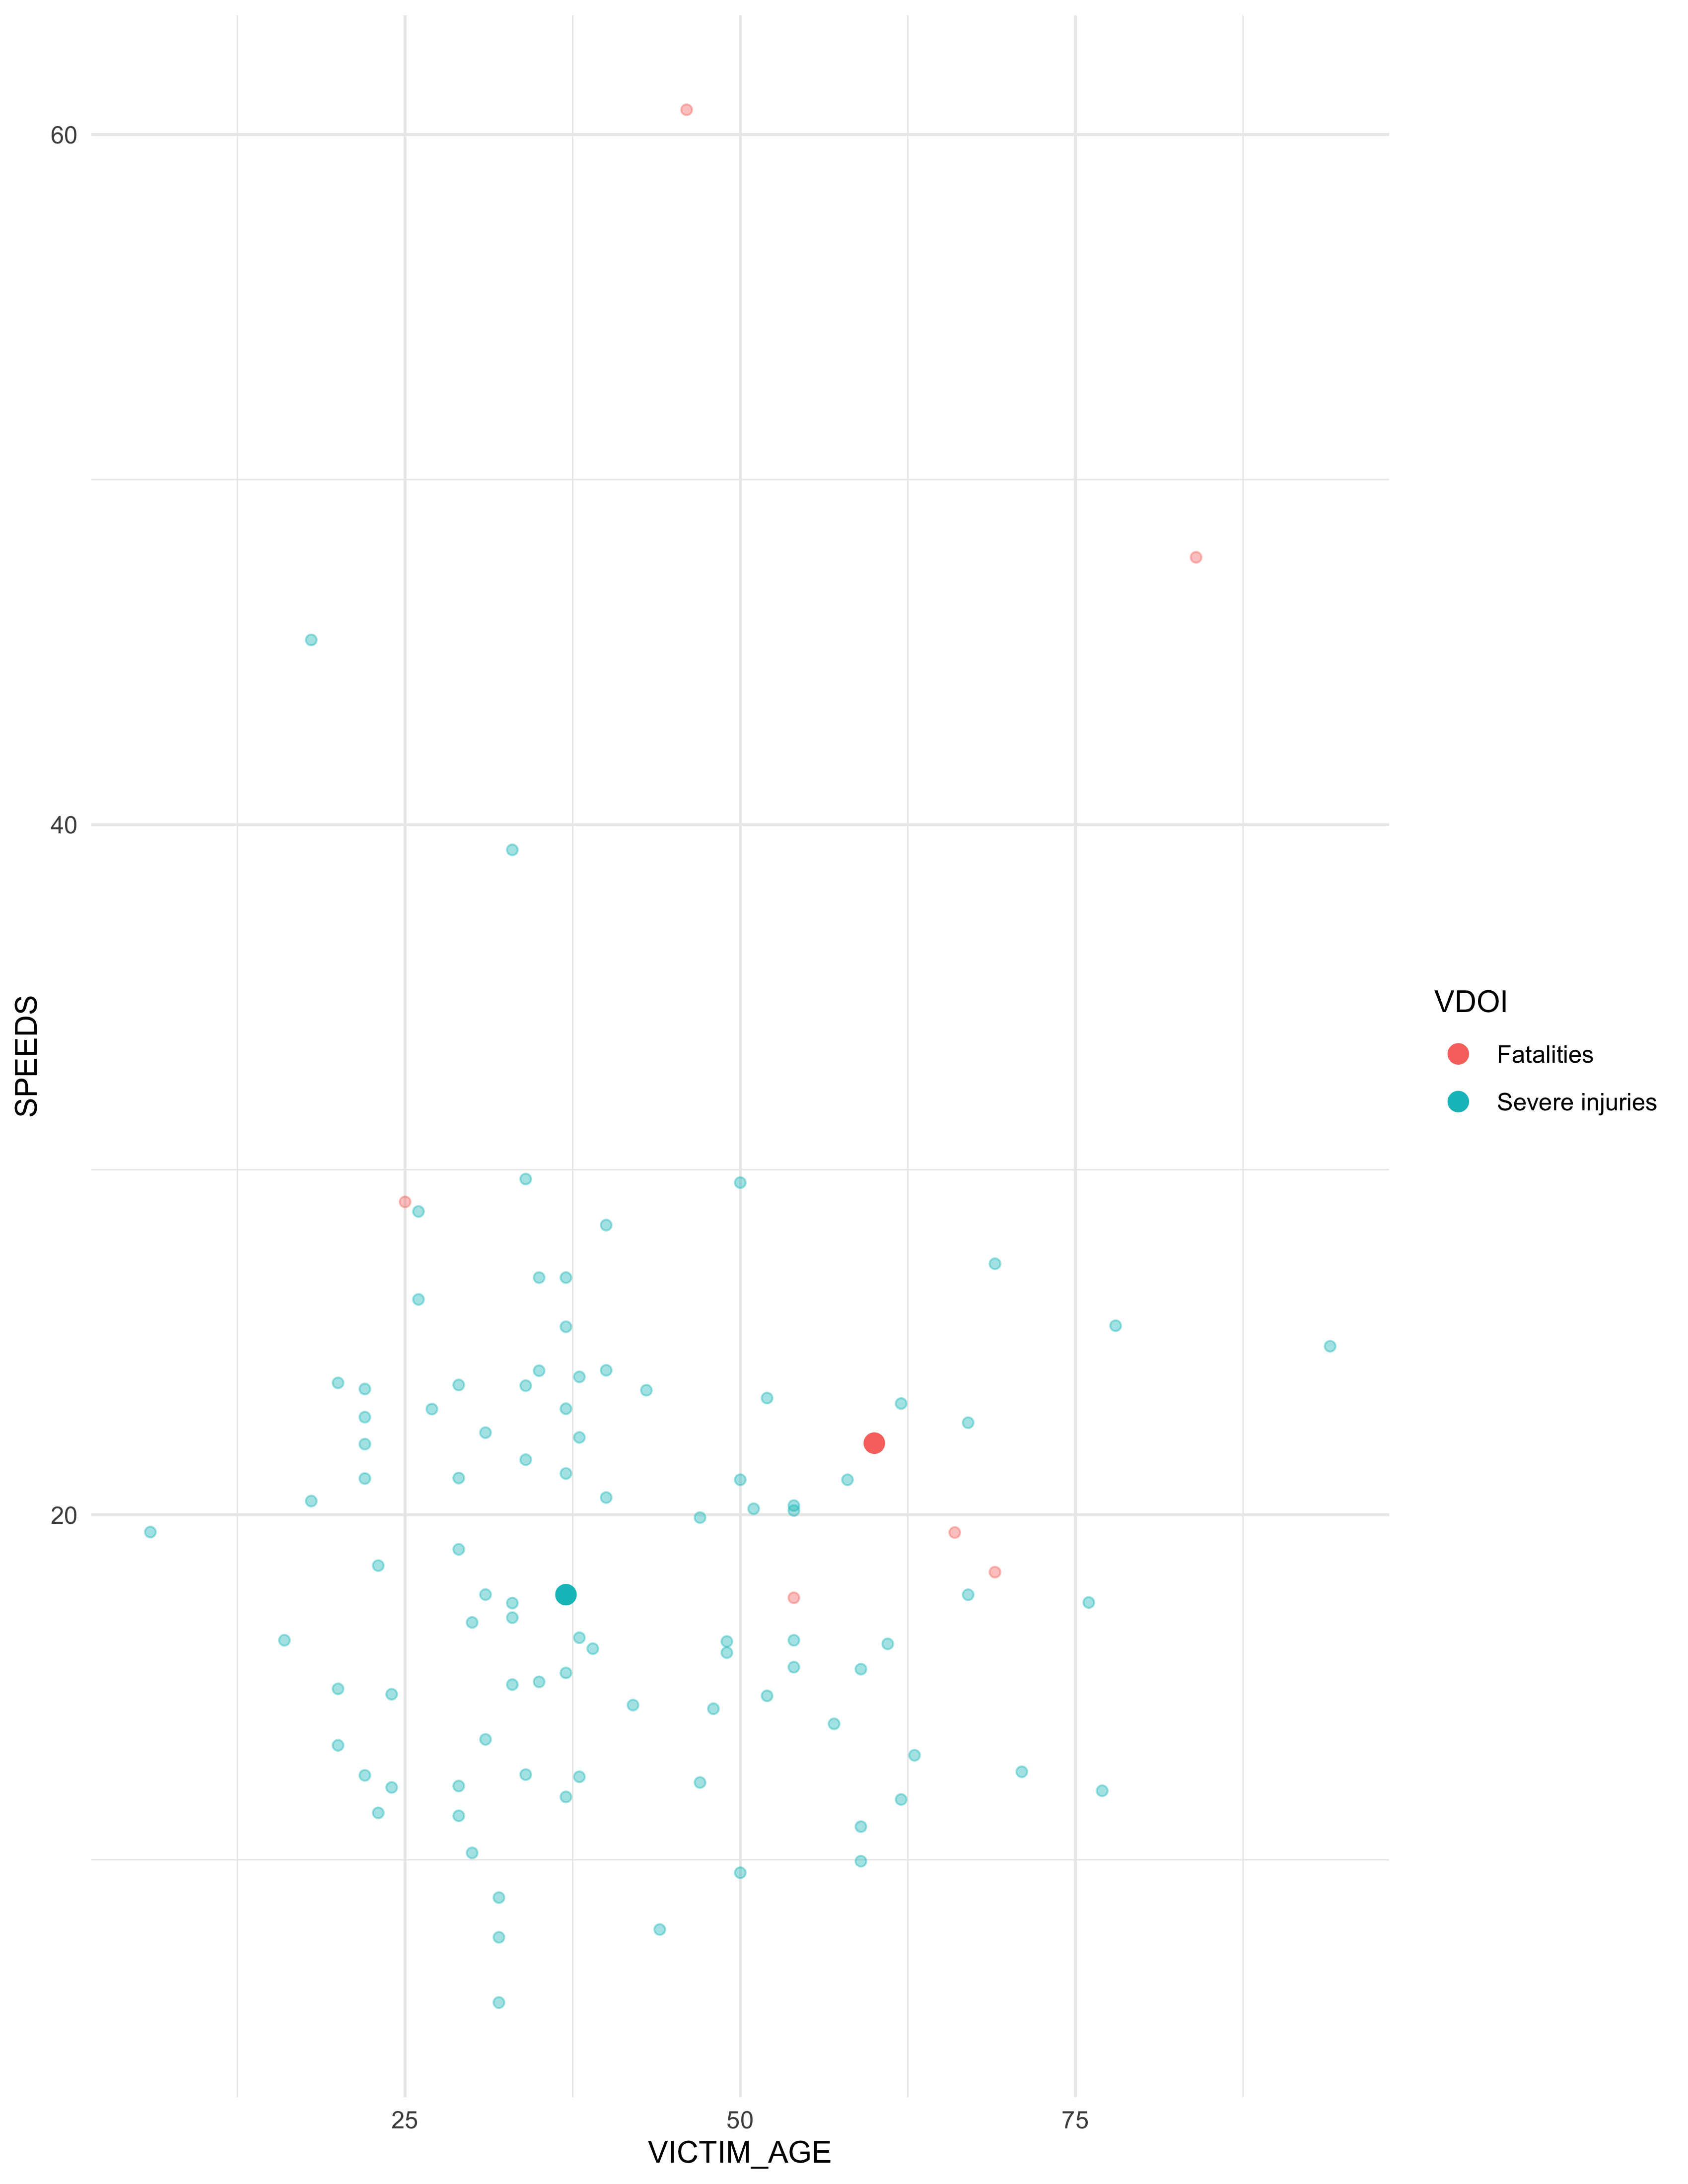

In [35]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() +
geom_point(aes(x = VICTIM_AGE, y = SPEEDS, color = VDOI), data = cvs_age, alpha = 0.4) +
geom_point(aes(x = VICTIM_AGE, y = SPEEDS, color = VDOI), data = cvs_age_ag, size = 3) +
theme_minimal()

# Bar chart: accidents (by severity) by parties involved

In [36]:
cvs_parties = cvs[['VDOI', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 
                   'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT']]
cvs_parties = cvs_parties.groupby('VDOI').sum().reset_index()
cvs_parties = cvs_parties.T
cvs_parties = cvs_parties[1:]
cvs_parties.columns = ["Count1", "Count2"]

cvs_parties

,Count1,Count2
PEDESTRIAN_ACCIDENT,4,39
BICYCLE_ACCIDENT,1,13
MOTORCYCLE_ACCIDENT,0,18
TRUCK_ACCIDENT,0,1


In [37]:
cvs_parties = pd.DataFrame(pd.concat([cvs_parties["Count1"], cvs_parties["Count2"]], axis = 0))
cvs_parties["VDOI"] = pd.Series(["Fatality","Fatality","Fatality","Fatality",
                                 "Severe injury","Severe injury","Severe injury","Severe injury"]).values
cvs_parties["Parties"] = cvs_parties.index

In [38]:
cvs_parties.columns = ["Count", "VDOI", "Parties"]
cvs_parties

,Count,VDOI,Parties
PEDESTRIAN_ACCIDENT,4,Fatality,PEDESTRIAN_ACCIDENT
BICYCLE_ACCIDENT,1,Fatality,BICYCLE_ACCIDENT
MOTORCYCLE_ACCIDENT,0,Fatality,MOTORCYCLE_ACCIDENT
TRUCK_ACCIDENT,0,Fatality,TRUCK_ACCIDENT
PEDESTRIAN_ACCIDENT,39,Severe injury,PEDESTRIAN_ACCIDENT
BICYCLE_ACCIDENT,13,Severe injury,BICYCLE_ACCIDENT
MOTORCYCLE_ACCIDENT,18,Severe injury,MOTORCYCLE_ACCIDENT
TRUCK_ACCIDENT,1,Severe injury,TRUCK_ACCIDENT


In [39]:
%R -i cvs_parties

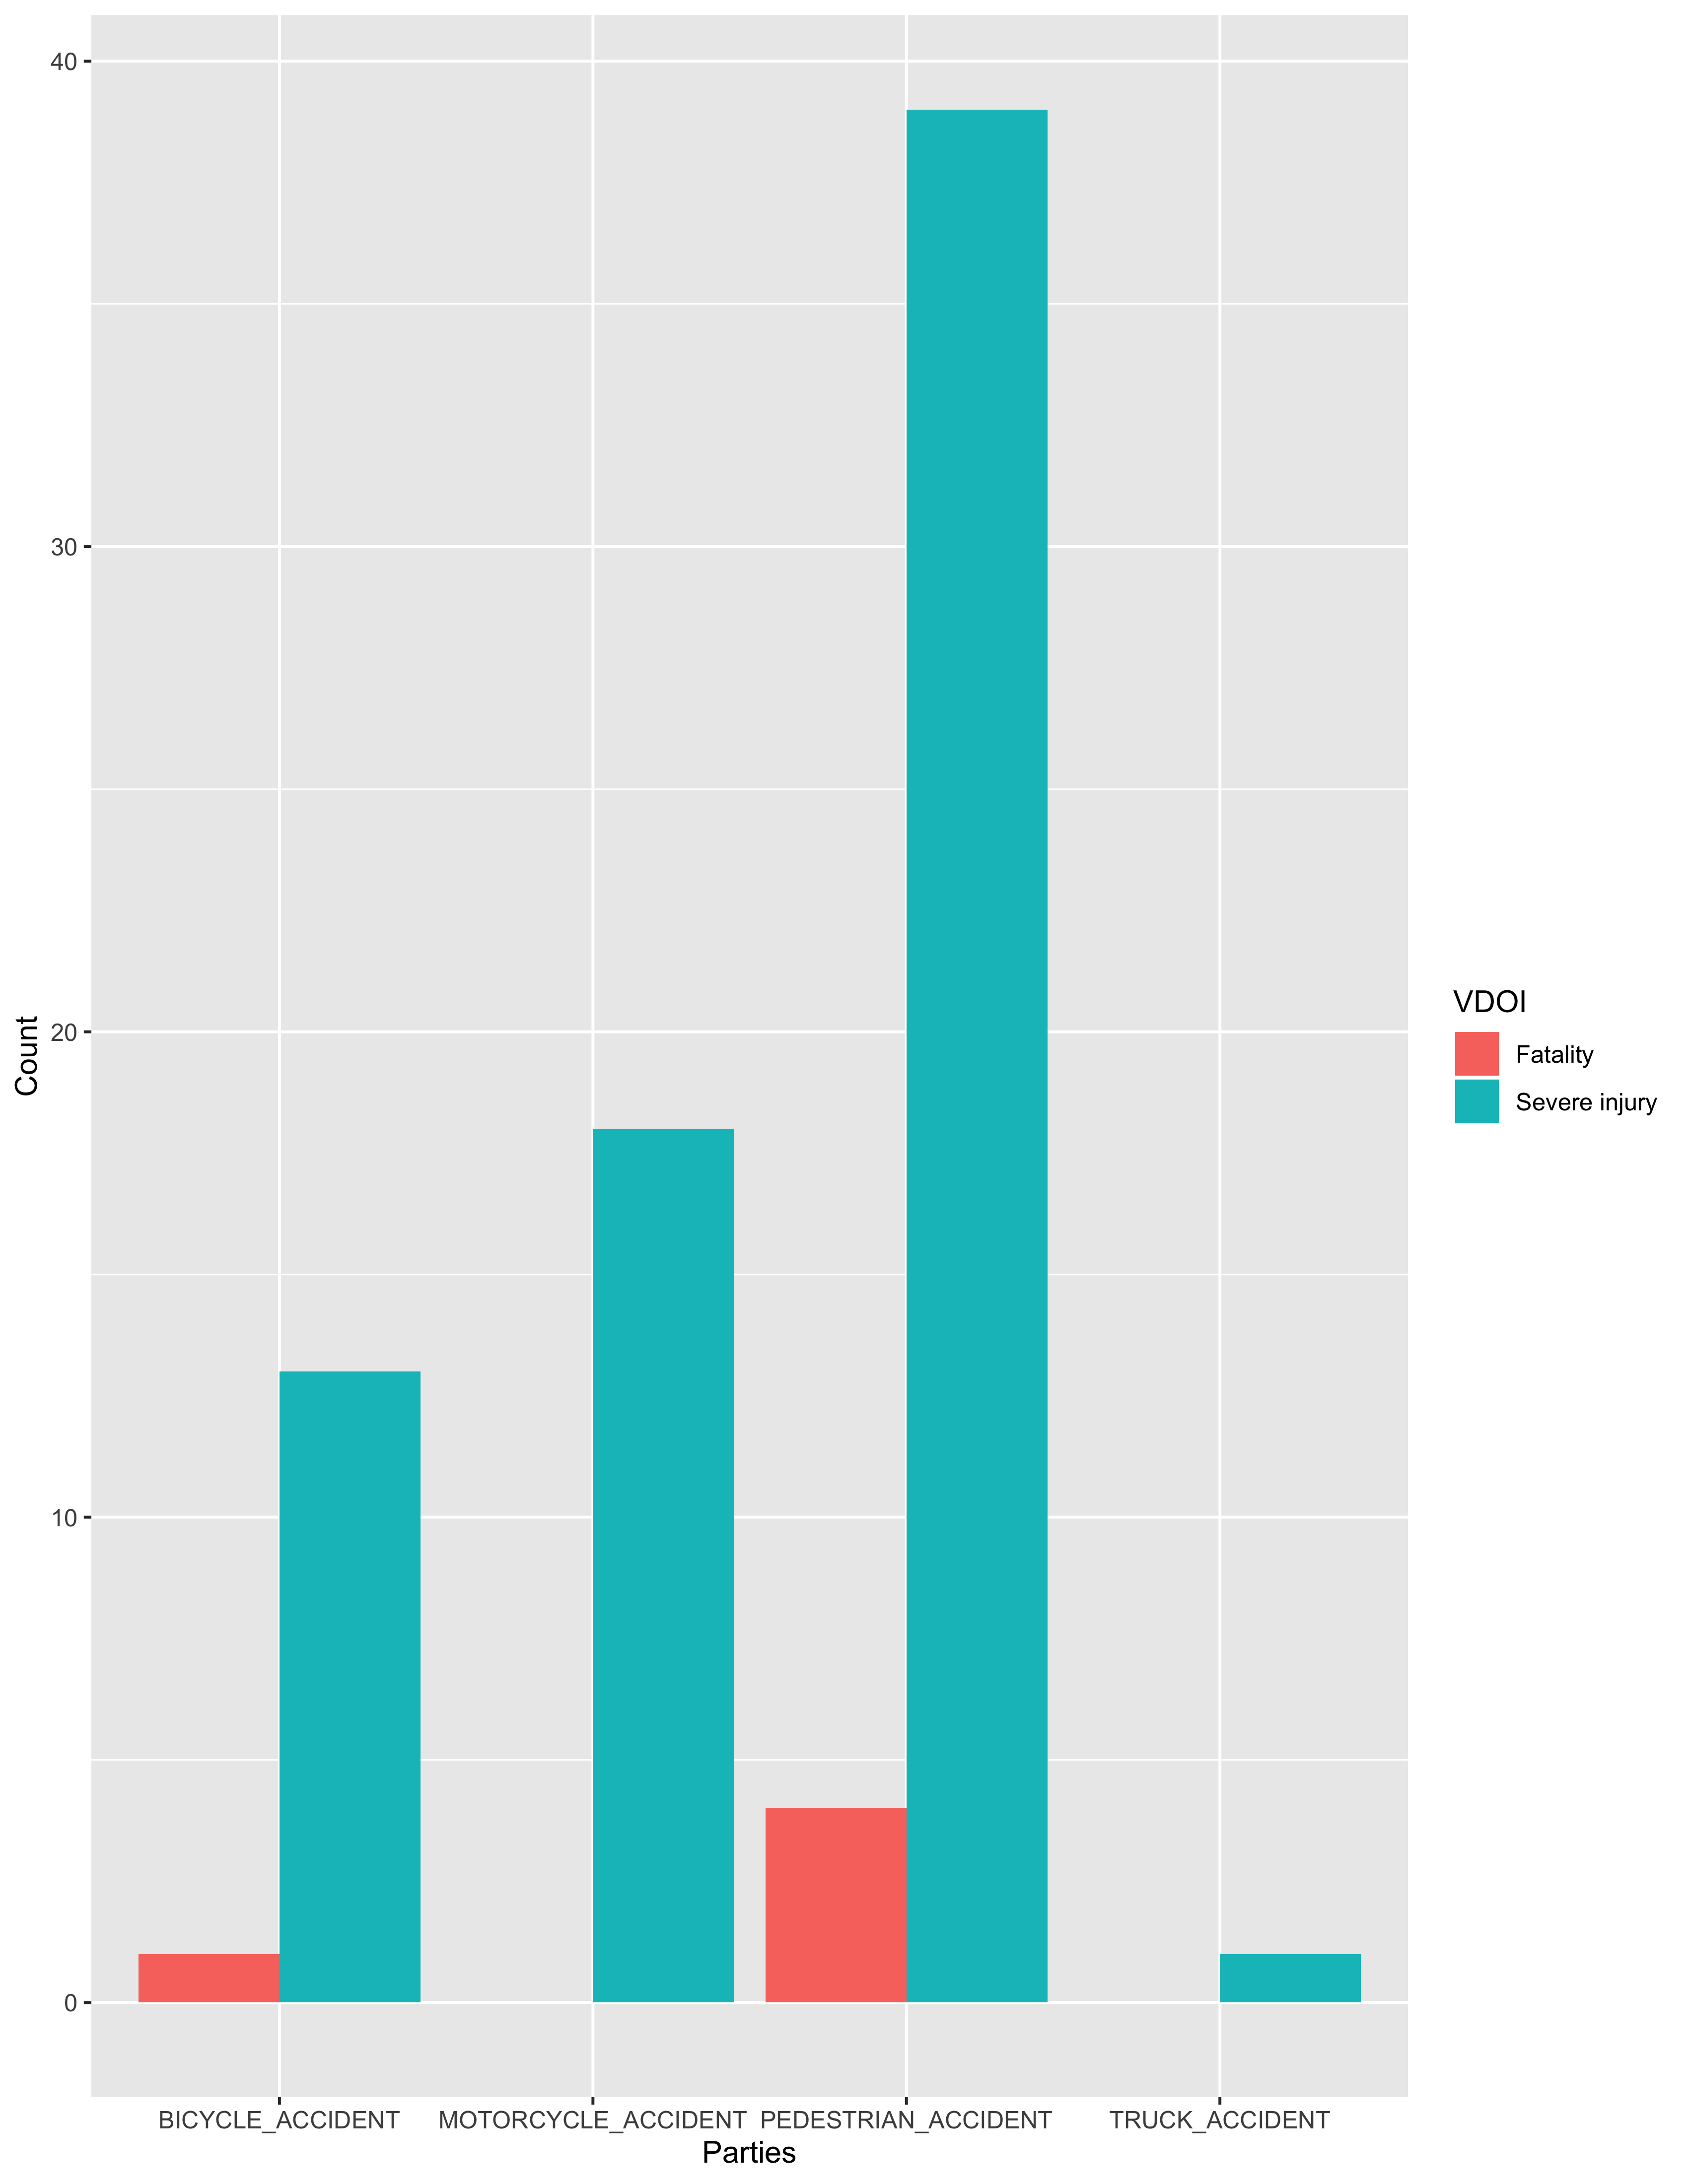

In [40]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() +
geom_bar(aes(x = Parties, y = Count, group = VDOI, fill = VDOI), data = cvs_parties, 
         stat = "identity", position = position_dodge())

# Time of day and severity

In [41]:
%%R

ggplot() +
geom_histogram(aes(x = cvs))

R[write to console]: Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.

R[write to console]: Error: Elements must equal the number of rows or 1



RRuntimeError: Error: Elements must equal the number of rows or 1


# Alcohol involved or not and VDOI

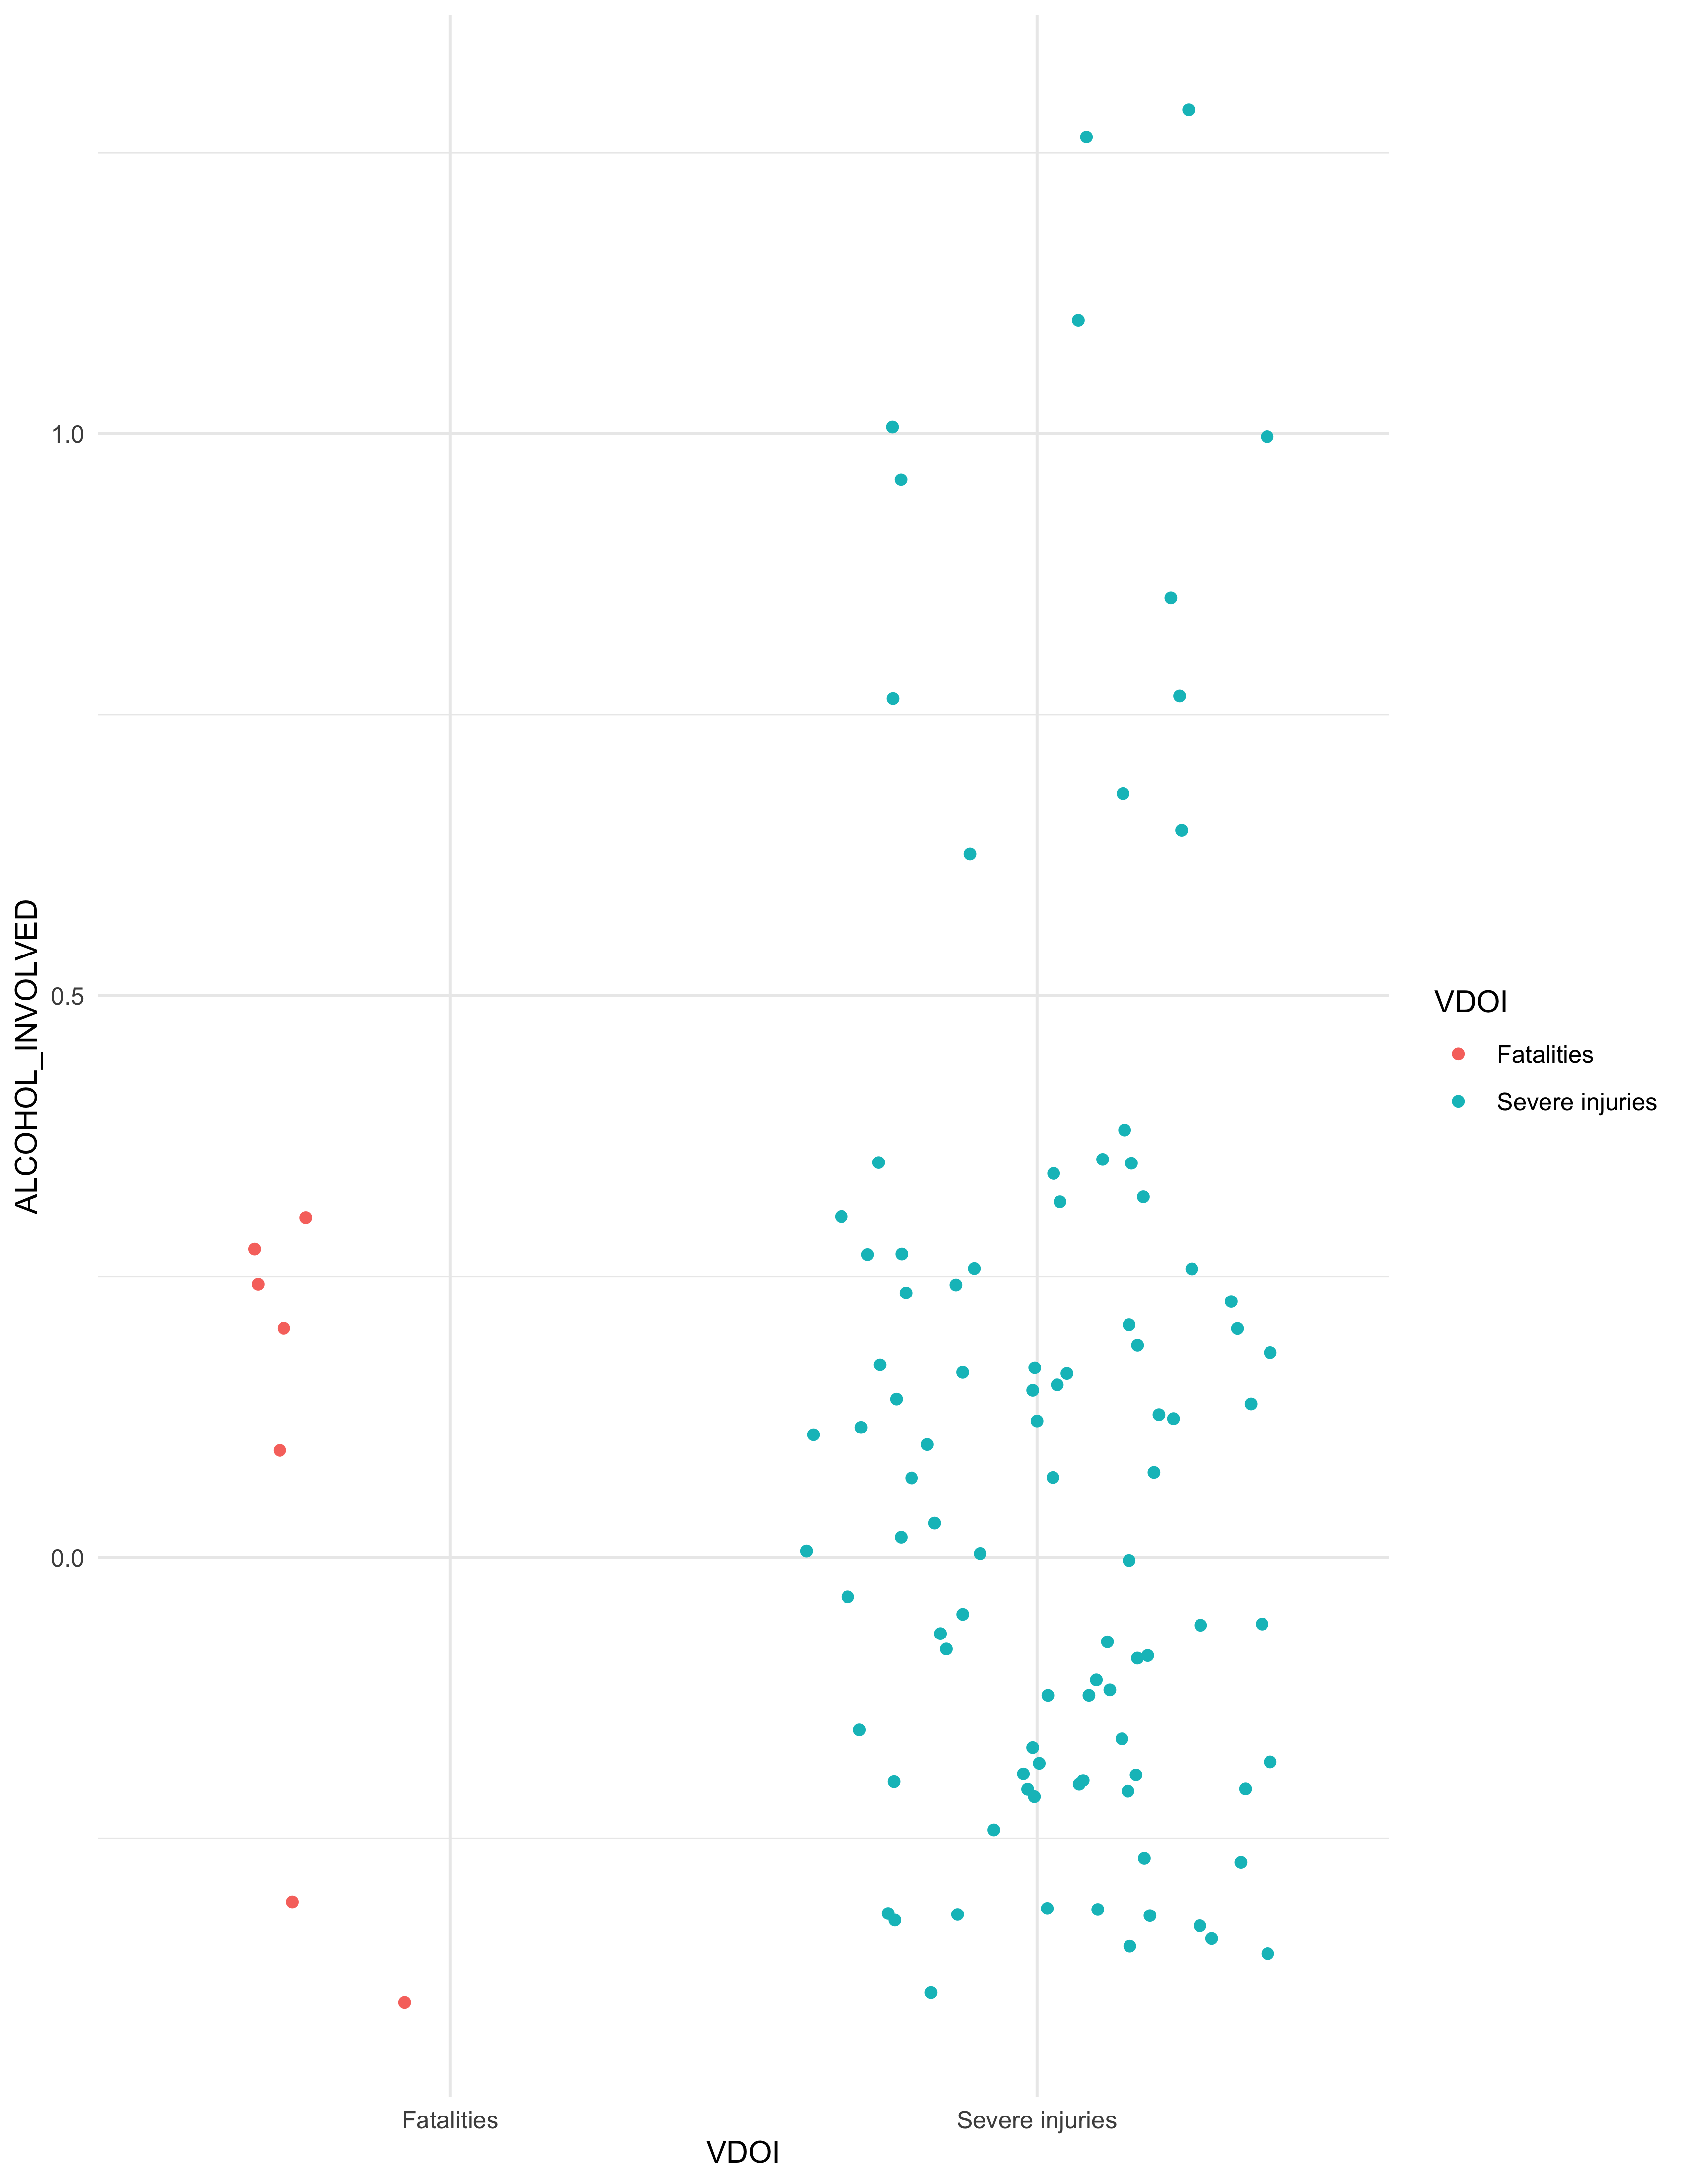

In [45]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() +
geom_point(aes(x = VDOI, y = ALCOHOL_INVOLVED, color = VDOI), data = cvs, position = "jitter") +
theme_minimal()